In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Capstone Project
First: Go out and find a dataset of interest. It could be from one of our recommended resources, some other aggregation, or scraped yourself. Just make sure it has lots of variables in it, including an outcome of interest to you.

Second: Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

Third: Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power and experiment with both.

So, here is the deliverable: Prepare a slide deck and 15 minute presentation that guides viewers through your model. Be sure to cover a few specific things:

* A specified research question your model addresses
* How you chose your model specification and what alternatives you compared it to
* The practical uses of your model for an audience of interest
* Any weak points or shortcomings of your model

In [16]:
import os
from IPython import get_ipython
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', None)
import pandas_profiling as pp
import numpy as np
import datetime as dt   
import matplotlib
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
import seaborn as sns
# Load models
from sklearn import ensemble
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.naive_bayes import BernoulliNB

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.decomposition import PCA 

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


 ## How much you should take for your AirBnB listing as a host?
 This capstone project is using data from AirBnB. <br/> In particular each data point respresents one listing, rented out in Berlin, Germany.
 As a host you might want to know what is a reasonable price for your listing. This project builds a model which can suggest a price. <br/>
 Let's dive into the data.

In [17]:
# Data Source: https://www.kaggle.com/brittabettendorf/berlin-airbnb-data
df = pd.read_csv("listings.csv")
pp.ProfileReport(df, check_correlation=True).to_file(outputfile="Main/3.7_ProfileOfBerlinAirBnB_RAW.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.7_ProfileOfBerlinAirBnB_RAW.html

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: Us

 ### Variable descriptions
 * id
 * name
 * host_id
 * host_name
 * neighbourhood_group
 * neighbourhood
 * latitude
 * longitude
 * room_type
 * price
 * minimum_nights
 * number_of_reviews
 * last_review
 * reviews_per_month
 * calculated_host_listings_count
 * availability_365

In [18]:
# Feature Engineering and Selection

# Rename our target variable (Y)
df['y_price'] = df['price']
# Transform the date variable into something a ML model can use. 
# In this case we calculate the number of days passed since the last review. After that we have an integer.
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_last_review'] = (df['last_review'] - dt.datetime(2018, 12, 31)).dt.days

# Drop unnecessary columns
df = df.drop(columns=[
    'name', # we won't do any NLP here
    'last_review', # already converted into 'days_since_last_review'
    'price', # was copied into 'y_price'
    'id', # just a increasing number
])

# Cleaning: Get rid of outliers
# Drop examples where 
# the price is higher than 500€ 
# and lower than 10€
df = df[df['y_price'] > 10] # 22522 - 22491 = 31 --> under 0.1% of all data
df = df[df['y_price'] < 500] # 22491 - 22405 = 86 --> under 0.4% of all data
# remove all listings which require a minimum stay of more than 500 nights
df = df[df['minimum_nights'] < 500] # 22405 - 22399 = 6 --> under 0.1% of all data


In [19]:
# See the relation of every numeric feature with the Y (price)
plt.figure(figsize=(30, 30),)

df.sort_values(by=['minimum_nights'])
plt.subplot(3, 3, 1)
plt.scatter(df['minimum_nights'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of nights', font)
plt.title('Minimum nights to stay', font)

df.sort_values(by=['number_of_reviews'])
plt.subplot(3, 3, 2)
plt.scatter(df['number_of_reviews'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of reviews', font)
plt.title('Reviews count', font)

df.sort_values(by=['calculated_host_listings_count'])
plt.subplot(3, 3, 3)
plt.scatter(df['calculated_host_listings_count'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of listings', font)
plt.title('Host listings count', font)

df.sort_values(by=['availability_365'])
plt.subplot(3, 3, 4)
plt.scatter(df['availability_365'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of days', font)
plt.title('All year availability', font)

df.sort_values(by=['days_since_last_review'])
plt.subplot(3, 3, 5)
plt.scatter(df['days_since_last_review'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of days', font)
plt.title('Days since last review', font)

df.sort_values(by=['reviews_per_month'])
plt.subplot(3, 3, 6)
plt.scatter(df['reviews_per_month'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('number of reviews per month', font)
plt.title('Review per month', font)

plt.subplot(3, 3, 7)
plt.scatter(df['latitude'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('latitude in degrees', font)
plt.title('Latitude', font)

plt.subplot(3, 3, 8)
plt.scatter(df['longitude'], df['y_price'], color='red')
plt.ylim([0, max(df['y_price']) + 100])
plt.ylabel('price in €', font)
plt.xlabel('longitude in degrees', font)
plt.title('Longitude', font)

plt.savefig('Main/3.7_Viz_Numeric_Features.png', dpi=100)
plt.close()

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


 #### Plot interpretation
 Except "availability_365" all other features show some kind of pattern or releation.

/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/ec2-user/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: Us

                                host_id  latitude  longitude  minimum_nights  \
host_id                            1.00      0.01      -0.04           -0.06   
latitude                           0.01      1.00      -0.11            0.02   
longitude                         -0.04     -0.11       1.00           -0.06   
minimum_nights                    -0.06      0.02      -0.06            1.00   
number_of_reviews                 -0.15      0.04      -0.02           -0.04   
reviews_per_month                  0.18      0.04      -0.04           -0.08   
calculated_host_listings_count    -0.05      0.04      -0.04            0.06   
availability_365                  -0.01      0.01      -0.08            0.18   
y_price                           -0.01      0.04      -0.05           -0.00   
days_since_last_review             0.18      0.02      -0.04           -0.05   

                                number_of_reviews  reviews_per_month  \
host_id                                     -0.

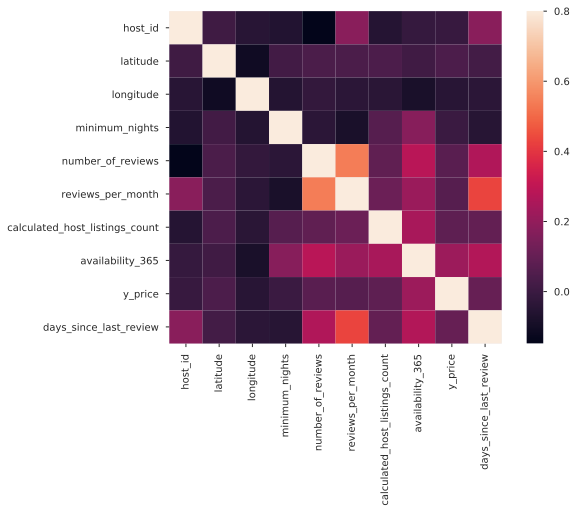

In [20]:
# Cleaning: Fill NaNs
values_to_fill = {
    'days_since_last_review': df.days_since_last_review.mean(), 
    'reviews_per_month': df.reviews_per_month.mean(),
    'latitude': df.latitude.mean(),
    'longitude': df.longitude.mean()
    }
df = df.fillna(value=values_to_fill)

# Do second data profile report on the cleaned data
pp.ProfileReport(df, check_correlation=True, pool_size=15).to_file(outputfile="Main/3.7_ProfileOfBerlinAirBnB_CLEAN.html")
# See the webpage at: https://github.com/RobKnop/ThinkfulDataScienceBootcamp/blob/master/Main/3.7_ProfileOfBerlinAirBnB_CLEAN.html

# Check for correlation
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

 #### Findings
 1. Correlation to y (price) is low: < 0.22
 2. Multicollinearity is low

 #### Our key evaluation metric to optimize on is root mean squared error

 #### Models to try:
 1. Linear Regression
 4. RandomForestRegressor
 5. KNN
 6. Support Vector Machine
 7. GradientBoosting Regression
 8. (Also use of KSelectBest, GridSearch, PCA)

In [21]:
# Normalize
mm_scaler = MinMaxScaler()
df[['longitude']] = mm_scaler.fit_transform(df[['longitude']].values)
df[['latitude']] = mm_scaler.fit_transform(df[['latitude']].values)
df[['minimum_nights']] = mm_scaler.fit_transform(df[['minimum_nights']].values)
df[['number_of_reviews']] = mm_scaler.fit_transform(df[['number_of_reviews']].values)
df[['reviews_per_month']] = mm_scaler.fit_transform(df[['reviews_per_month']].values)
df[['availability_365']] = mm_scaler.fit_transform(df[['availability_365']].values)
df[['calculated_host_listings_count']] = mm_scaler.fit_transform(df[['calculated_host_listings_count']].values)
df[['days_since_last_review']] = mm_scaler.fit_transform(df[['days_since_last_review']].values)

# Define X and y
X = df.drop(columns=[
                    'y_price', # is the Y
                    'neighbourhood_group', # is categorical 
                    'neighbourhood', # is categorical 
                    'room_type', # is categorical 
                    'host_id', # it should not be an input, model should suggest a price independent of the host id 
                    'host_name' # a name should not be a good predictor (also add bias)
                    ])
X = pd.concat([X, pd.get_dummies(df['neighbourhood_group'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['neighbourhood'])], axis=1)
X = pd.concat([X, pd.get_dummies(df['room_type'])], axis=1)

y = df['y_price']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [22]:
# Linear Regression: Instantiate and fit our model.
regr = linear_model.LinearRegression()
#print(data['Sales'].values)

regr.fit(X_train, y_train)

# Inspect the results.
y_pred = regr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', regr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1244.9200903964895
    rms error is: 35.283425151145536
    R^2 score:  0.3032450592756517
    Cross Validated Score: -8084315944863031296.00 (+/- 32336148635065393152.00)
SelectKBest:

PCA:
    mean-squared: 1352.2922436354918
    rms error is: 36.77352639651918
    R^2 score:  0.2734677236923385
    Cross Validated Score: -5620486015875508338688.00 (+/- 22481944014540442173440.00)
'''
# Cross validate
score = cross_val_score(regr, X, y, cv=5, n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


mean-squared: 1244.9200903964895
rms error is: 35.283425151145536
R^2 score:  0.3032450592756517
Cross Validated Score: -8084315944863031296.00 (+/- 32336148635065393152.00)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [23]:
# See the impact of each feature
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients.columns = ['feature', 'coef_value']
coefficients.sort_values(by=['coef_value'], ascending=False)

,feature,coef_value
9,Friedrichshain-Kreuzberg,6922540294579.26
12,Mitte,5806199926372.39
155,Entire home/apt,4984469480381.53
156,Private room,4984469480344.74
157,Shared room,4984469480334.49
18,Tempelhof - Schöneberg,3439738780650.79
14,Pankow,3028643715652.54
123,Rummelsburger Bucht,2129327052256.79
54,Friedrichsfelde Nord,2129327052242.48
26,Alt-Hohenschönhausen Süd,2129327052240.77


In [24]:
# KNN:
for k in range(22, 30, 1):
    print('\nk = ', k)
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print('mean-squared:', mean_squared_error(y_test, y_pred))
    rmse_val = rmse(y_pred, y_test)
    print("rms error is: " + str(rmse_val))
    print('KNN R^2 score: ', knn.score(X_test, y_test))
    
    knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
    knn_w.fit(X_train, y_train)
    y_pred = knn_w.predict(X_test)
    print('\nmean-squared:', mean_squared_error(y_test, y_pred))
    rmse_val = rmse(y_pred, y_test)
    print("rms error is: " + str(rmse_val))
    print('KNN_dist R^2 score: ', knn_w.score(X_test, y_test))


k =  22
mean-squared: 1231.073818901269
rms error is: 35.086661552522564
KNN R^2 score:  0.3109945189793928

mean-squared: 1182.6077386518461
rms error is: 34.38906423053477


KeyboardInterrupt: 

In [25]:
# Run best KNN model
k = 24
knn = KNeighborsRegressor(n_neighbors=k)
knn_w = KNeighborsRegressor(n_neighbors=k, weights='distance')
knn_w.fit(X_train, y_train)
# Inspect the results.
y_pred = knn_w.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('R^2 score: ', knn_w.score(X_test, y_test))
"""
Plan:
    mean-squared: 1181.845364092119
    rms error is: 34.37797789417108
    R^2 score:  0.33854662403183555
    Unweighted R^2 score: 0.26 (+/- 0.06)
    Weighted R^2 score: 0.26 (+/- 0.08)
"""
# Cross validate
score = cross_val_score(knn, X, y, cv=5, n_jobs=-1)
print("Unweighted R^2 score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, y, cv=5, n_jobs=-1)
print("Weighted R^2 score: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))


mean-squared: 1181.845364092119
rms error is: 34.37797789417108
R^2 score:  0.33854662403183555
Unweighted R^2 score: 0.26 (+/- 0.06)
Weighted R^2 score: 0.26 (+/- 0.08)


In [26]:
# RandomForestRegressor:
rfr = ensemble.RandomForestRegressor(n_jobs=-1, verbose=1)

# Choose some parameter combinations to try
parameters = {'n_estimators': [16, 32, 64, 96], 
              #'max_features': ['log2', 'sqrt','auto'], 
              #'criterion': ['entropy', 'gini'],
              'max_depth': [5, 10, 13, 16], 
              'min_samples_split': [2, 3, 5],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(rfr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   18.3s


[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:  1.3min


[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.7s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [27]:
# Run best RandomForestRegressor model:
rfr = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=16,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=7, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=96, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

rfr.fit(X_train, y_train) 
y_pred = rfr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('RandomForest R^2 score: ', rfr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1114.9156553846422
    rms error is: 33.390352729263654
    RandomForest R^2 score:  0.3760057393460754
    Cross Validated Score: 0.32 (+/- 0.08)
SelectKBest(120):
    mean-squared: 1117.430849408185
    rms error is: 33.42799499533566
    RandomForest R^2 score:  0.374598039465334
    Cross Validated Score: 0.32 (+/- 0.09)
'''
# Cross validate
score = cross_val_score(rfr, X, y, cv=5, n_jobs=-1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    0.5s finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  96 out of  96 | elapsed:    0.0s finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done  96 out of  96 | elapsed:    0.0s finished



mean-squared: 1122.5487800007384
rms error is: 33.504459106225475
RandomForest R^2 score:  0.37173364402810527


Cross Validated Score: 0.31 (+/- 0.09)


In [28]:
#SVM: 
svr = SVR(
        kernel='rbf', 
        degree=3, 
        gamma='scale', 
        coef0=0.0, tol=0.001, 
        C=1.0, 
        epsilon=0.1, 
        shrinking=True, 
        cache_size=200, 
        verbose=1, 
        max_iter=-1
        )

svr.fit(X_train, y_train) 
y_pred = svr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('SVM R^2 score: ', svr.score(X_test, y_test)) 
'''
Plain:
    mean-squared: 1415.110354346454
    rms error is: 37.61795255388644
    SVM R^2 score:  0.20799323694177607
    Cross Validated Score: 0.20 (+/- 0.10)
'''
# Cross validate
score = cross_val_score(svr, X, y, cv=5, n_jobs=-1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

[LibSVM]
mean-squared: 1415.110354346454
rms error is: 37.61795255388644
SVM R^2 score:  0.20799323694177607
Cross Validated Score: 0.20 (+/- 0.10)


In [29]:
#Gradient Boosting
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, n_iter_no_change=50, learning_rate=0.3)

# Choose some parameter combinations to try
parameters = {
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5, 7],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(gbr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.7min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [30]:
# Run the best Gradient Boosting model: 
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=5,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test))
'''
Plain:
    mean-squared: 1142.1625258267968
    rms error is: 33.795895103204415
    Gradient Boost R^2 score:  0.3607562532575337
    Cross Validated Score: 0.31 (+/- 0.07)
'''
# Cross validate
score = cross_val_score(gbr, X, y, cv=5, n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

      Iter       Train Loss   Remaining Time 
         1        1710.7331           23.90s
         2        1595.8422           23.18s
         3        1532.7715           22.94s
         4        1495.2896           22.80s
         5        1472.9422           22.67s
         6        1452.2054           21.64s
         7        1434.1188           21.32s
         8        1419.1054           20.48s
         9        1408.2836           19.88s
        10        1397.5990           20.03s
        20        1331.8079           17.88s
        30        1302.4227           17.10s
        40        1283.9076           16.19s
        50        1269.5945           15.54s
        60        1253.9613           14.87s
        70        1241.9622           14.44s
        80        1234.6195           13.93s
        90        1227.7335           13.46s
       100        1218.6240           13.06s

mean-squared: 1142.1370954735487
rms error is: 33.79551886676025
Gradient Boost R^2 score:  0.3607

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.2s finished


In [31]:
#Try SelectKBest
X_selKBest = SelectKBest(k=120).fit_transform(X, y)

# Use PCA (but it is not working better)
# sklearn_pca = PCA(n_components=100)
# X_pca = sklearn_pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selKBest, y, test_size=0.2, random_state=20)

In [32]:
#Gradient Boosting
gbr = ensemble.GradientBoostingRegressor(n_estimators=500, n_iter_no_change=50, learning_rate=0.3)

# Choose some parameter combinations to try
parameters = {
              'max_depth': [2, 3, 5, 10], 
              'min_samples_split': [2, 3, 5, 7],
              'min_samples_leaf': [1, 2, 5, 7]
             }

# Run the grid search
grid_obj = GridSearchCV(gbr, parameters, cv=3, n_jobs=-1, verbose=1)
grid_obj.fit(X, y)

# Set the clf to the best combination of parameters
grid_obj.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:  2.8min finished


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
# Gradient Boosting: 
gbr = ensemble.GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=7,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=500, n_iter_no_change=50, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=1, warm_start=False)

gbr.fit(X_train, y_train) 
y_pred = gbr.predict(X_test)
print('\nmean-squared:', mean_squared_error(y_test, y_pred))
rmse_val = rmse(y_pred, y_test)
print("rms error is: " + str(rmse_val))
print('Gradient Boost R^2 score: ', gbr.score(X_test, y_test))
'''
Plain:
    mean-squared: 1142.1625258267968
    rms error is: 33.795895103204415
    Gradient Boost R^2 score:  0.3607562532575337
    Cross Validated Score: 0.31 (+/- 0.07)s
SelectKBest:
    mean-squared: 1122.9432515976998
    rms error is: 33.51034544133651
    Gradient Boost R^2 score:  0.37151286677800033
    Cross Validated Score: 0.31 (+/- 0.07)
PCA:
    mean-squared: 1317.735332331002
    rms error is: 36.30062440690248
    Gradient Boost R^2 score:  0.29203376335601083
    Cross Validated Score: 0.29 (+/- 0.12)
'''
# Cross validate
score = cross_val_score(gbr, X, y, cv=5, n_jobs=-1, verbose=1)
print("Cross Validated Score: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

      Iter       Train Loss   Remaining Time 
         1        1647.0702           31.77s
         2        1518.4611           31.40s
         3        1445.9573           31.03s
         4        1400.7860           30.72s
         5        1371.8917           30.31s
         6        1353.0365           30.22s
         7        1338.4677           30.15s
         8        1324.0335           28.64s
         9        1312.5130           27.31s
        10        1296.8255           26.57s
        20        1232.9502           22.53s
        30        1194.8460           20.55s
        40        1174.4690           19.55s
        50        1154.5518           18.68s
        60        1136.9013           17.83s
        70        1125.1331           17.10s
        80        1110.2457           16.54s
        90        1097.9581           16.19s
       100        1085.0540           15.78s

mean-squared: 1118.6616577105813
rms error is: 33.44639977203196
Gradient Boost R^2 score:  0.3739

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


 #### Final model evaluation:
 The best model is Random Forest. It has the lowest rms error of 33.39. <br/>
 Folowed by Gradient Boosting with 33.51 root mean squared error.